In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

from scipy.spatial import cKDTree

In [2]:
import liana as li

In [3]:
# slide names and x, y offsets
slides = {'A1':[3.5, 18],
          'B1':[3, 10.5],
          'C1':[1, 13.5],}

In [4]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

In [5]:
rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
rna.obs[['x', 'y']] = rna.obsm['spatial']

msi_raw = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

MSI

In [7]:
msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

/tmp/ipykernel_146181/2697352618.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [8]:
# copy raw intensities
msi.layers['raw'] = msi.X

# normalize and cluster
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)
sc.pp.pca(msi)
sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
sc.tl.leiden(msi, resolution=0.00001)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [9]:
# get positions; NOTE: x and y are mirrored in the msi data
positions = msi_raw[['y', 'x']].values.copy()

# estimate scaling factor
sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
sfactor

608.9063

In [10]:
# inverse y
positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
# offset
x_offset = slides[slide][0]
y_offset = slides[slide][1]

positions[:, 0] = positions[:, 0] + x_offset
positions[:, 1] = positions[:, 1] + y_offset

msi.obs[['array_row', 'array_col']] = positions

# scale
positions = positions * sfactor * 0.95

In [11]:
msi.uns = rna.uns.copy()

In [12]:
msi.obsm['spatial'] = positions
msi.obs[['x', 'y']] = positions

In [13]:
# remove cells that are not in the tissue
msi = msi[msi.obs['leiden'] != '1', :]

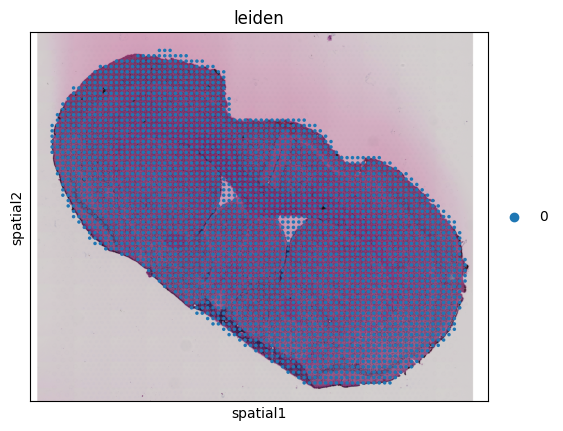

In [20]:
sc.pl.spatial(msi, color="leiden")

In [15]:
import muon as mu

In [16]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


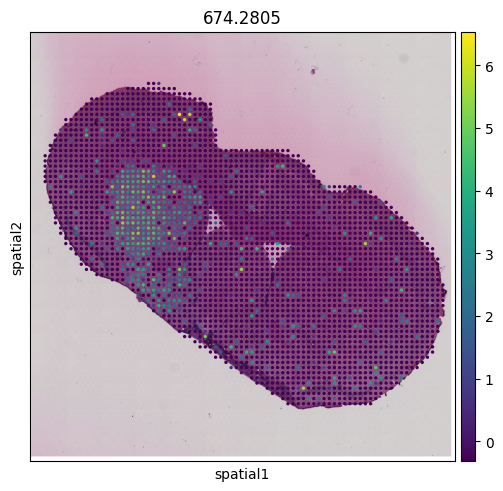

In [17]:
sq.pl.spatial_scatter(msi, color=['674.2805']) # plot dopamine

In [18]:
# swap back to raw intensities
mdata.mod['msi'].X = mdata.mod['msi'].layers['raw'].copy()
del mdata.mod['msi'].layers['raw']

In [19]:
mdata.write_h5mu(slide_path + "/sma.h5mu")

... storing 'lesion' as categorical
... storing 'region' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
